<a href="https://colab.research.google.com/github/mescovedo/Exercicios-Aleatorios/blob/main/ADALINE_Para_Filtro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
#cd /content/drive/My Drive/Colab Notebooks/Int. Comp./Exp. 2

In [ ]:
#ls

In [ ]:
# ANN Adaptive FIR Identification with ADALINE
# numpy/scipy/tensorflow/keras
#
# ICIN Ex2  - Matheus Escovedo da Costa


import numpy as np
import matplotlib.pyplot as plt
import csv
from scipy import signal

print('Ex2 ICIN ENE/UnB 1/9/2018')
#melhores valores encontrados
delays = 1  # order of the FIR
mu = 0.001     # learning rate
band = '01'   # Choose '01' or '05':PRBS signal with [0-0.01] of Nyquist band
#band = '05'   #                     or PRBS signal with [0-0.05] of Nyquist band
              # [0-1] band means a signal that can change as fasta as on each sample


g1=signal.lti([1],(1, .2, 1)) 
#this also works!:

g2=signal.lti([3],(1, 2, 1))

t1=np.linspace(0,79.9,800)   # first time interval, for g1
t2=np.linspace(80,119.9,400) # second time interval, for g2


print(g2)

Ex2 ICIN ENE/UnB 1/9/2018
TransferFunctionContinuous(
array([3.]),
array([1., 2., 1.]),
dt: None
)


In [ ]:
#u=idinput(1500,'PRBS',[0 0.01]); u=u';     # Matlab commands
#%u=zeros(size(u))+1
#[Y,Zf]=filter(gd.num{1,1},gd.den{1,1},u(1:800));
#[Y2]=filter(gd2.num{1,1},gd2.den{1,1},u(801:1500),Zf);

([<matplotlib.lines.Line2D at 0x7f97abf58b90>],
 Text(0.5,1,'PRBS [0-0.05] of Nyquist Band'))

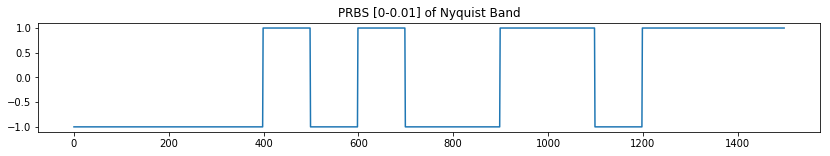

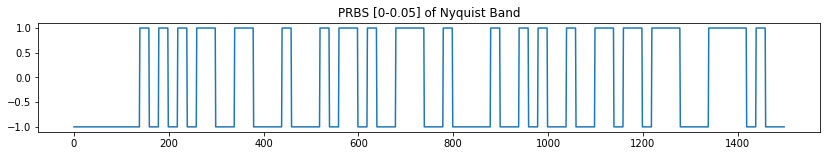

In [ ]:
# load both PRBS signals from file 
data=np.genfromtxt('idinp.csv',dtype=float,delimiter=',',skip_header=1)    

u01=data[:,0]
u05=data[:,1]
plt.figure(1,figsize=(14,2))
plt.plot(u01,label='u01'),plt.title('PRBS [0-0.01] of Nyquist Band')
plt.figure(2,figsize=(14,2))
plt.plot(u05,label='u05'),plt.title('PRBS [0-0.05] of Nyquist Band')


In [ ]:
u1=u01[0:800]              # initializa vectors
u2=u01[800:1200]  
u3=u05[0:800]              # initializa vectors
u4=u05[800:1200]

if band=='01':             # i=0,1 choose one of the signals, .01 or 0.05 band.
        u1=u01[0:800]     
        u2=u01[800:1200]  
        to1,y1,x1=signal.lsim(g1,u01[0:800],t1)
        to2,y2,x2=signal.lsim(g2,u01[800:1200],t2,X0=x1[-1])
        _,y3,_=signal.lsim(g1,u05[0:800],t1)
        _,y4,_=signal.lsim(g2,u05[800:1200],t2,X0=x1[-1])
else:
        u1=u05[0:800]     
        u2=u05[800:1200]  
        to1,y1,x1=signal.lsim(g1,u05[0:800],t1)
        to2,y2,x2=signal.lsim(g2,u05[800:1200],t2,X0=x1[-1])
        _,y3,_=signal.lsim(g1,u01[0:800],t1)
        _,y4,_=signal.lsim(g2,u01[800:1200],t2,X0=x1[-1])
        
t=np.concatenate((t1,t2))
u=np.concatenate((u1,u2))
y=np.concatenate((y1,y2))
u7=np.concatenate((u3,u4))
y5=np.concatenate((y3,y4))


In [ ]:
# u  0 1 2 3 4 5 6 7 8 9 10 11...     1197 1198 1199 1200
#tdl 0
#w   0
#ys  u[0]*w[0]
#tdl 1 0
#w   1 0
#ys  u[1]*w[1] + u[0]*w[0]
#tdl 2 1 0
#w   2 1 0
#ys  u[2]*w[2] + u[1]*w[1] + u[0]*w[0]

def adaline(u, *arg):                          # receives (u) or ,(u,w) - produces ys
                                               # 
    w = np.zeros(delays,dtype=float)           # Initialize weights
    wt= np.zeros((len(u),delays),dtype=float)  # register time evolution of the weights
    ys= np.zeros(len(u), dtype=float)
    et= np.zeros(len(u), dtype=float)
    err=0
    
    if len(arg)==0: adapt=1                    # adapt weights w
    else: w = arg;  adapt=0                    # receive and mantain w - simulate only
            
    # fill in "acausal" zeros , for t<0
    ud=np.zeros(delays,dtype=float)
    ue=np.insert(ud,delays,u)    

    for i in range(len(u)):      
        for j in range(delays): ys[i]+=ue[i-j]*w[j]  # simulate ADALINE
        for j in range(delays): 
            et[i]=y[i]-ys[i]
            if adapt==1:
                w[j]+=mu*et[i]*ue[i-j]               # Widrow-Hoff delta rule
                wt[i,j] = w[j]                       # store w history
        err+=(y[i]-ys[i])**2
    mse=err/len(u)
    
    return ys, et, mse, wt

In [ ]:
# run adaptive ADALINE
ya, e, msea, wt = adaline(u)

# run with Fixed NN weights - the last values from the previous run 
yf, e, msef, wr =adaline(u7,*wt[-1,:])
msef

5.12437121892054

In [ ]:
# NEWLIND
# y1 = w0*1 + w1*u1[0] + w2*u1[-1] + w3*u1[-2] + ...
# y2 = w0*1 + w1*u2[0] + w2*u2[-1] + w3*u2[-2] + ...
# ...
# yN = w0*1 + w1*u2[0] + w2*u2[-1] + w3*u2[-2] + ...
#
#                               Y_Nx1   - Measurements
# Y = U*Psi'                    U_NxM   - Regressors    
# U'Y = U'U*Psi'                Psi_1xM - Parameter Vector
# Psi'= (U'U)-1 U' Y            (U'U)-1 U' - Pseudoinverse - MMQ  

# NEWLIND - Design a ADALINE using all samples at once: the pseudoinverse
U=np.zeros((len(u)+delays,delays))
for j in range(delays):         # build U with copies of shifted u
    U[j:len(u)+j,j]=u

Y=np.zeros((len(u)+delays))
Y[0:len(y)]=y

#wd = inv(U'U)*U'*y
wd = np.matmul(np.matmul(np.linalg.inv(np.matmul(np.transpose(U),U)),np.transpose(U)),Y)


# NEWLIND Fixed weights wd - Designed
yd, e, msed, wr =adaline(u7,*wd)
print('Delta = ', msef, 'Pseudo-Inversa = ',msed)


('Delta = ', 5.12437121892054, 'Pseudo-Inversa = ', 5.901448831191206)


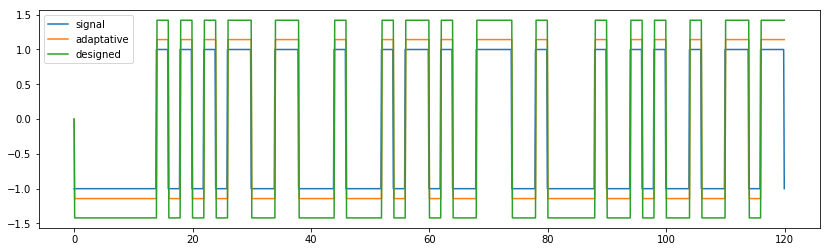

In [ ]:
plt.figure(1,figsize=(14,4))
plt.plot(t, u7,label='signal')
plt.plot(t, yf,label='adaptative')
plt.plot(t, yd,label='designed')
plt.legend()